# Language Identification Model


In [77]:
### TO DEBUGGIN'
_DEBUG = True

## Load Package

In [61]:
# to load and manipulate data
import pandas as pd
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split

# to make neural netowrk model, sequencing and tokenizing
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

# to evaluate and display results
from sklearn.metrics import  confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
import squarify

## Load Data

In [63]:
## print paths
for root, dirs, files in os.walk('./data'):
    for filename in files:
        print(os.path.join(root,filename))

./data/language.json
./data/sentences.csv


In [80]:
%%time
## vamos a medir el TIME de esta shit

df = pd.read_csv("./data/sentences.csv")

CPU times: user 5.59 s, sys: 678 ms, total: 6.27 s
Wall time: 6.5 s


## Data Cleansing

In [65]:
## eliminar columna maldita que esta de mas ID
df.drop(columns=['id'],inplace=True)

In [66]:
df.head()

,lan_code,sentence
0,cmn,我們試試看！
1,cmn,我该去睡觉了。
2,cmn,你在干什麼啊？
3,cmn,這是什麼啊？
4,cmn,今天是６月１８号，也是Muiriel的生日！


In [67]:
## [x] no hay sentencias sin code - :D!
if _DEBUG:
    display(df.describe())

,lan_code,sentence
count,10341812,10341812
unique,404,10330761
top,eng,Bravo!
freq,1586621,11


Code LANGUAGE with less frequency than 10: sentence    277
dtype: int64


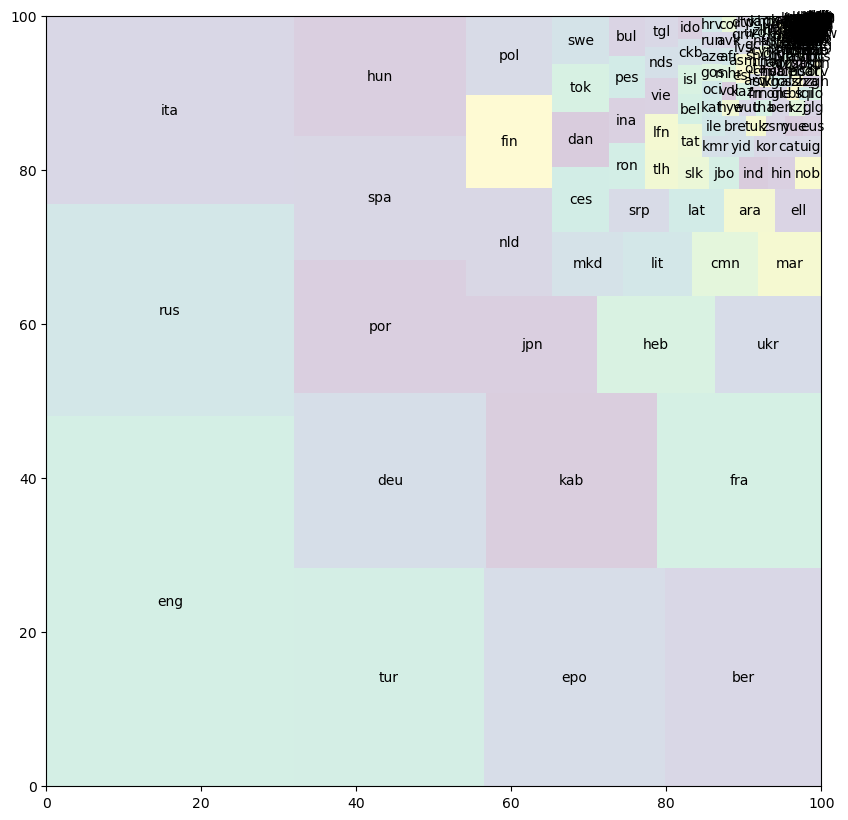

In [68]:
if _DEBUG:
    df_exploration = df.groupby("lan_code").count().sort_values("sentence",ascending = False)

    #!# posiblemente cuando se entrene el modelo los de baja frecuencia no va a predecir correctamente
    #!# como posible opcion 1 analizar con todo y luego ver el impacto de remover esos code lan con freq 1
    
    count_freq_1 = df_exploration[df_exploration.sentence<=10].sum()
    print("Code LANGUAGE with less frequency than 10: {}".format(count_freq_1))
    
    ## GRAPH - TREEMAP
    sizes_treemap = df_exploration["sentence"].tolist()
    labels_treemap = df_exploration.index.values.tolist()
    
    plt.figure(figsize=(10,10))
    squarify.plot(sizes = sizes_treemap, label = labels_treemap, alpha=0.2)
    plt.show()
    
    del df_exploration

## Preprocessing Data - FULL dataset sentences

In [81]:
# ENCODING CLASSES (cod language)
classes_list = list(df.lan_code.unique())
print("Count of Classes: {}".format(len(classes_list)))

Count of Classes: 404


In [82]:
## crearemos dos dic para usos posteriores de transformacion

cls_to_num = {
    cls : i
    for i,cls in enumerate(classes_list)
}

num_to_cls = {
    i : cls
    for cls,i in cls_to_num.items()
}

In [83]:
## cambiar el string-code por int-code para ingresarlos al modelo

display(df.head())
df.lan_code = df.lan_code.map(cls_to_num).astype(int)
display(df.head())

,id,lan_code,sentence
0,1,cmn,我們試試看！
1,2,cmn,我该去睡觉了。
2,3,cmn,你在干什麼啊？
3,4,cmn,這是什麼啊？
4,5,cmn,今天是６月１８号，也是Muiriel的生日！


,id,lan_code,sentence
0,1,0,我們試試看！
1,2,0,我该去睡觉了。
2,3,0,你在干什麼啊？
3,4,0,這是什麼啊？
4,5,0,今天是６月１８号，也是Muiriel的生日！


## Subset Train & Test

In [84]:
# Lista de Sentencias
X = df.pop('sentence').values

# Lista de CODE LAN 
y = df.copy().values.T[0]

if _DEBUG:
    display(X)
    display(y)

In [85]:
## liberamos memoria virtual (RAM)
del df

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    train_size=0.8,
    random_state=50,
    shuffle = True
)

## liberamos memoria virtual (RAM)
del X, y

# Tokenization

Usaremos este metodo para procesar los datos input para el modelo:

mas info: https://towardsdatascience.com/tokenization-for-natural-language-processing-a179a891bad4


### Sentencias -> Secuencias de palabras


In [87]:
## parametros

NUM_WORDS = 1000000
MAX_LEN = 150
NUM_CLASSES = 404 # esto lo sacamos de arriba

In [88]:
def tokenize_and_sequence(
                            train_sentences,
                            test_sentences
                            ):
    tok = Tokenizer(num_words = NUM_WORDS, oov_token='<OOV>')
    tok.fit_on_texts(train_sentences)
    
    # training set
    train_seq = tok.texts_to_sequences(train_sentences)
    train_seq = pad_sequences(
                    train_seq,
                    padding = 'post',
                    maxlen = MAX_LEN,
                    truncating = 'post'
                )
    
    # testing set
    test_seq = tok.texts_to_sequences(test_sentences)
    test_seq = pad_sequences(
                    test_seq,
                    padding = 'post',
                    maxlen = MAX_LEN,
                    truncating = 'post'
                )
    if _DEBUG:
        print(tok.get_config())
    
    return train_seq, test_seq, tok

In [17]:
%%time
## call function 
X_train, X_test, tok = tokenize_and_sequence(X_train, X_test)

# WARNING: problemas de tiempo de respuesta, se debe cambiar la config del notebook

CPU times: user 2min 27s, sys: 2.99 s, total: 2min 30s
Wall time: 2min 34s


In [20]:
if _DEBUG:
    print(X_train.shape)
    print(X_test.shape)

(8273449, 150)
(2068363, 150)


# Model NLP

## Build Model

- Embedding layer son capas de palabras previamente entrenadas como GloVe, se usan mucho en NLP.
- LSTM : capa de memoria a largo plazo
- Dense: capa densa conectada normal
- Dropout: ayuda a evitar el sobreajuste en la entrada

Funciones de Activacion: https://towardsdatascience.com/7-popular-activation-functions-you-should-know-in-deep-learning-and-how-to-use-them-with-keras-and-27b4d838dfe6

Ocupamos:
- ReLu
- Softmax: se usa muy amenudo en la ultima capa de la red, como FA. dado que el resultado se podria interpretar como una D. P. 

In [21]:
## heredamos la clases tf.keras.model (Classic)
class NLPModel(tf.keras.Model):
    def __init__(self,
                vocad_dim = NUM_WORDS,
                max_len = MAX_LEN,
                num_classes = NUM_CLASSES):
        super().__init__()
        
        self.embedding = layers.Embedding(input_dim = vocad_dim, output_dim = 32, input_length = max_len)
        
        self.lstm1 = layers.Bidirectional(layers.LSTM(units = 32, return_sequences=True))
        self.lstm2 = layers.Bidirectional(layers.LSTM(16))
        
        self.dense = layers.Dense(64, activation = 'relu')
        
        self.dropout = layers.Dropout(0.5)
        
        self.classifier = layers.Dense(num_classes, activation = 'softmax')
        
    def call(self, inputs, training = False):
        x = self.embedding(inputs)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dense(x)
        if training:
            x = self.dropout(x, training = training)
        return self.classifier(x)

In [22]:
model = NLPModel()

In [24]:
## Especificamos la configuración de entrenamiento (optimizador, pérdida, métricas):
# uso de ADAM Algorithm

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

## Train Model

In [25]:
%%time
history = model.fit(
                    X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=512, 
                    epochs=10
)

Epoch 1/10


2022-09-29 23:25:16.463057: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 7808/16160 [=============>................] - ETA: 55:13 - loss: 0.6966 - accuracy: 0.8231

KeyboardInterrupt: 

In [ ]:
## datos del entrenamiento
history.history

## Evaluate Model